# Navigation using Double DQN

---

In this notebook, i will implement Double DQN and see how good is this Technique.

Note that the same parameters are applied to all the techniques I have used in this notebook as well as in other notebooks.

#### different techniques which can be used to imporve DQN
    '''
    * - Double DQN
    2 - Prioritized experience replay
    3 - Dueling DQN 
    4 - multi-step bootstrap targets (A3C) 
    5 - Distributional DQN 
    6 - Noisy DQN 

    ***** 
    Rainbow                         # combaination of these sex different techniques
    *****
    '''

### 1. Start the Environment


In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  

In [2]:
env = UnityEnvironment(file_name="Banana_Windows_x86_64/Banana_Windows_x86_64/Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Implementation

Now we will implement the idea of Double DQN. 

In [5]:
# import requiered packages 
import sys
import os
import random
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from collections import deque,namedtuple
import matplotlib.pyplot as plt
%matplotlib inline


In [6]:
# Determine if I want to train the agent on GPU (if available) or CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [7]:
# Our Enviroment
env_info = env.reset(train_mode=False)[brain_name] 
action_size = brain.vector_action_space_size
state = env_info.vector_observations[0]
state_size = len(state) 


In [8]:
# The model consist of 4 fully connected layer and output layer

class DQN(nn.Module):
    
    def __init__(self,state_size,action_size,seed):
        
        super(DQN,self).__init__()
        
        self.state_size  = state_size                     # the size of env states which = 37 
        self.action_size = action_size                    # the size of available actions in the env which = 4
        self.seed        = torch.manual_seed(seed) 
        
        
        self.fc1      = nn.Linear(self.state_size,32)        
        self.fc2      = nn.Linear(32,64)        
        self.fc3      = nn.Linear(64,64)
        self.fc4      = nn.Linear(64,64)
        
        self.actions  = nn.Linear(64,self.action_size)
    
    def forward(self,state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        
        qvals = self.actions(x)
        
        return qvals
    


In [9]:
class RLAgent():
    
    def __init__(self,state_size,action_size,buffer_size,batch_size,UPDATE_EVERY,
                 seed,gamma,TAU,alpha=5e-4):
        
        self.state_size = state_size
        self.action_size = action_size
        self.buffer_size   = buffer_size
        self.batch_size    = batch_size
        self.UPDATE_EVERY  = UPDATE_EVERY
        self.seed  = random.seed(seed)
        self.gamma = gamma
        self.alpha = alpha
        self.TAU   = TAU
 

        # Q-Network
        self.DQN_local = DQN(state_size, action_size, seed).to(device)
        #self.DQN_local.apply(self.weights_init)

        self.DQN_target = DQN(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.DQN_local.parameters(), lr=self.alpha)

        # Replay memory
        self.memory = ReplayBuffer(self.action_size, self.buffer_size, self.batch_size, self.seed)
        
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
        
    
    # weight xavier initialize
    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Linear') != -1:
            torch.nn.init.xavier_uniform(m.weight)
        
    def act(self,state,eps):
        
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.DQN_local.eval()
        with torch.no_grad():
            action_values = self.DQN_local(state)
        self.DQN_local.train()


        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy()).astype(np.int32)
        else:
            return random.choice(np.arange(self.action_size))
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)

        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % self.UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences, self.gamma)
    
    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones= experiences
        
        # Get expected Q values from local model 
        Q_expected = self.DQN_local(states)
        Q_expected = Q_expected.gather(1, actions)
        
        # Get next actions from local model
        next_actions = self.DQN_local(next_states).max(dim=1)[1].view(-1, 1).long().to(device)
        
        # Get expected Q values (for next states) from target model
        Q_targets_next =  self.DQN_target(next_states)
        # evaluatue next actions and Compute Q targets
        Q_targets = rewards + (gamma * Q_targets_next.gather(1,next_actions) * (1 - dones))


        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.DQN_local, self.DQN_target, self.TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [10]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [11]:
def train_agent(EPISODES=2000,max_ts=1000,eps_start=1.0,eps_decay=0.99,
                eps_min=0.01,gamma=0.99,alpha=5e-4,seed=6):

    buffer_size  = int(1e5)
    batch_size   = 64
    UPDATE_EVERY = 4
    TAU = 1e-3 
    

    
    Agent = RLAgent(state_size,action_size,buffer_size,batch_size,UPDATE_EVERY,
                    seed,gamma,TAU,alpha)
    scores   = []
    scores_window = deque(maxlen=100)
    eps  = eps_start
    
    solved = False
    for i_episode in range(1,EPISODES + 1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0
        for time_step in range(max_ts):

            action = Agent.act(state,eps)
            #print(type(action))
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished

            Agent.step(state, action, reward, next_state, done)

            state = next_state
            score += reward
            if done:
                break     

        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_min, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0 and solved !=True:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            torch.save(Agent.DQN_local.state_dict(), 'checkpoints/DoubleDQN.pth')
            solved = True
            break
            
    return scores 


In [12]:
Double_DQN_scores = train_agent()

Episode 100	Average Score: 1.18
Episode 200	Average Score: 4.20
Episode 300	Average Score: 9.01
Episode 400	Average Score: 12.32
Episode 436	Average Score: 13.00
Environment solved in 436 episodes!	Average Score: 13.00


In [13]:
env.close()

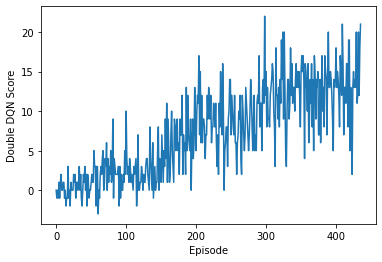

In [14]:
fig = plt.figure()
plt.plot(np.arange(len(Double_DQN_scores)), Double_DQN_scores)
plt.ylabel("Double DQN Score")
plt.xlabel("Episode")
plt.show()